In [1]:
"""
[2401XX]
* 
* 

[240105]
* 新增pipeline與columntransformer用法
* 新增voting ensembling

[TODO]
* 就是新增沒看過的數據分析法法啦

"""

'\n[V1]\n* Add MoA feature()\n* \n\n[V2]\n* \n* \n\n[TODO]\n* \n\n'

In [2]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

from warnings import filterwarnings
filterwarnings(action='ignore')

import matplotlib.pyplot as plt 
%matplotlib inline

In [3]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
df = pd.DataFrame(data=housing['data'], columns=housing['feature_names'])
df['target'] = housing['target']
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [8]:
# 描述性統計, 看離群值要不要補、最大最小值是否差異很大要處理，標準差大也要整理
pd.DataFrame(round(df.describe(), 2)).reset_index(drop=False)

,index,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,count,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00
1,mean,3.87,28.64,5.43,1.10,1425.48,3.07,35.63,-119.57,2.07
2,std,1.90,12.59,2.47,0.47,1132.46,10.39,2.14,2.00,1.15
3,min,0.50,1.00,0.85,0.33,3.00,0.69,32.54,-124.35,0.15
4,25%,2.56,18.00,4.44,1.01,787.00,2.43,33.93,-121.80,1.20
5,50%,3.53,29.00,5.23,1.05,1166.00,2.82,34.26,-118.49,1.80
6,75%,4.74,37.00,6.05,1.10,1725.00,3.28,37.71,-118.01,2.65
7,max,15.00,52.00,141.91,34.07,35682.00,1243.33,41.95,-114.31,5.00


In [10]:
from prettytable import PrettyTable

# 描述性統計，看缺失值，數據類型
table = PrettyTable()

table.field_names = ['Feature', 'Data Type', 'train Missing %']
for column in df.columns:
    #if column != 'Status':
    data_type = str(df[column].dtype)
    non_null_count_train = np.round(100-df[column].count()/df.shape[0]*100,1)
    
    table.add_row([column, str(df[column].dtype), non_null_count_train])

print(table)

+------------+-----------+-----------------+
|  Feature   | Data Type | train Missing % |
+------------+-----------+-----------------+
|   MedInc   |  float64  |       0.0       |
|  HouseAge  |  float64  |       0.0       |
|  AveRooms  |  float64  |       0.0       |
| AveBedrms  |  float64  |       0.0       |
| Population |  float64  |       0.0       |
|  AveOccup  |  float64  |       0.0       |
|  Latitude  |  float64  |       0.0       |
| Longitude  |  float64  |       0.0       |
|   target   |  float64  |       0.0       |
+------------+-----------+-----------------+


<Figure size 800x400 with 0 Axes>

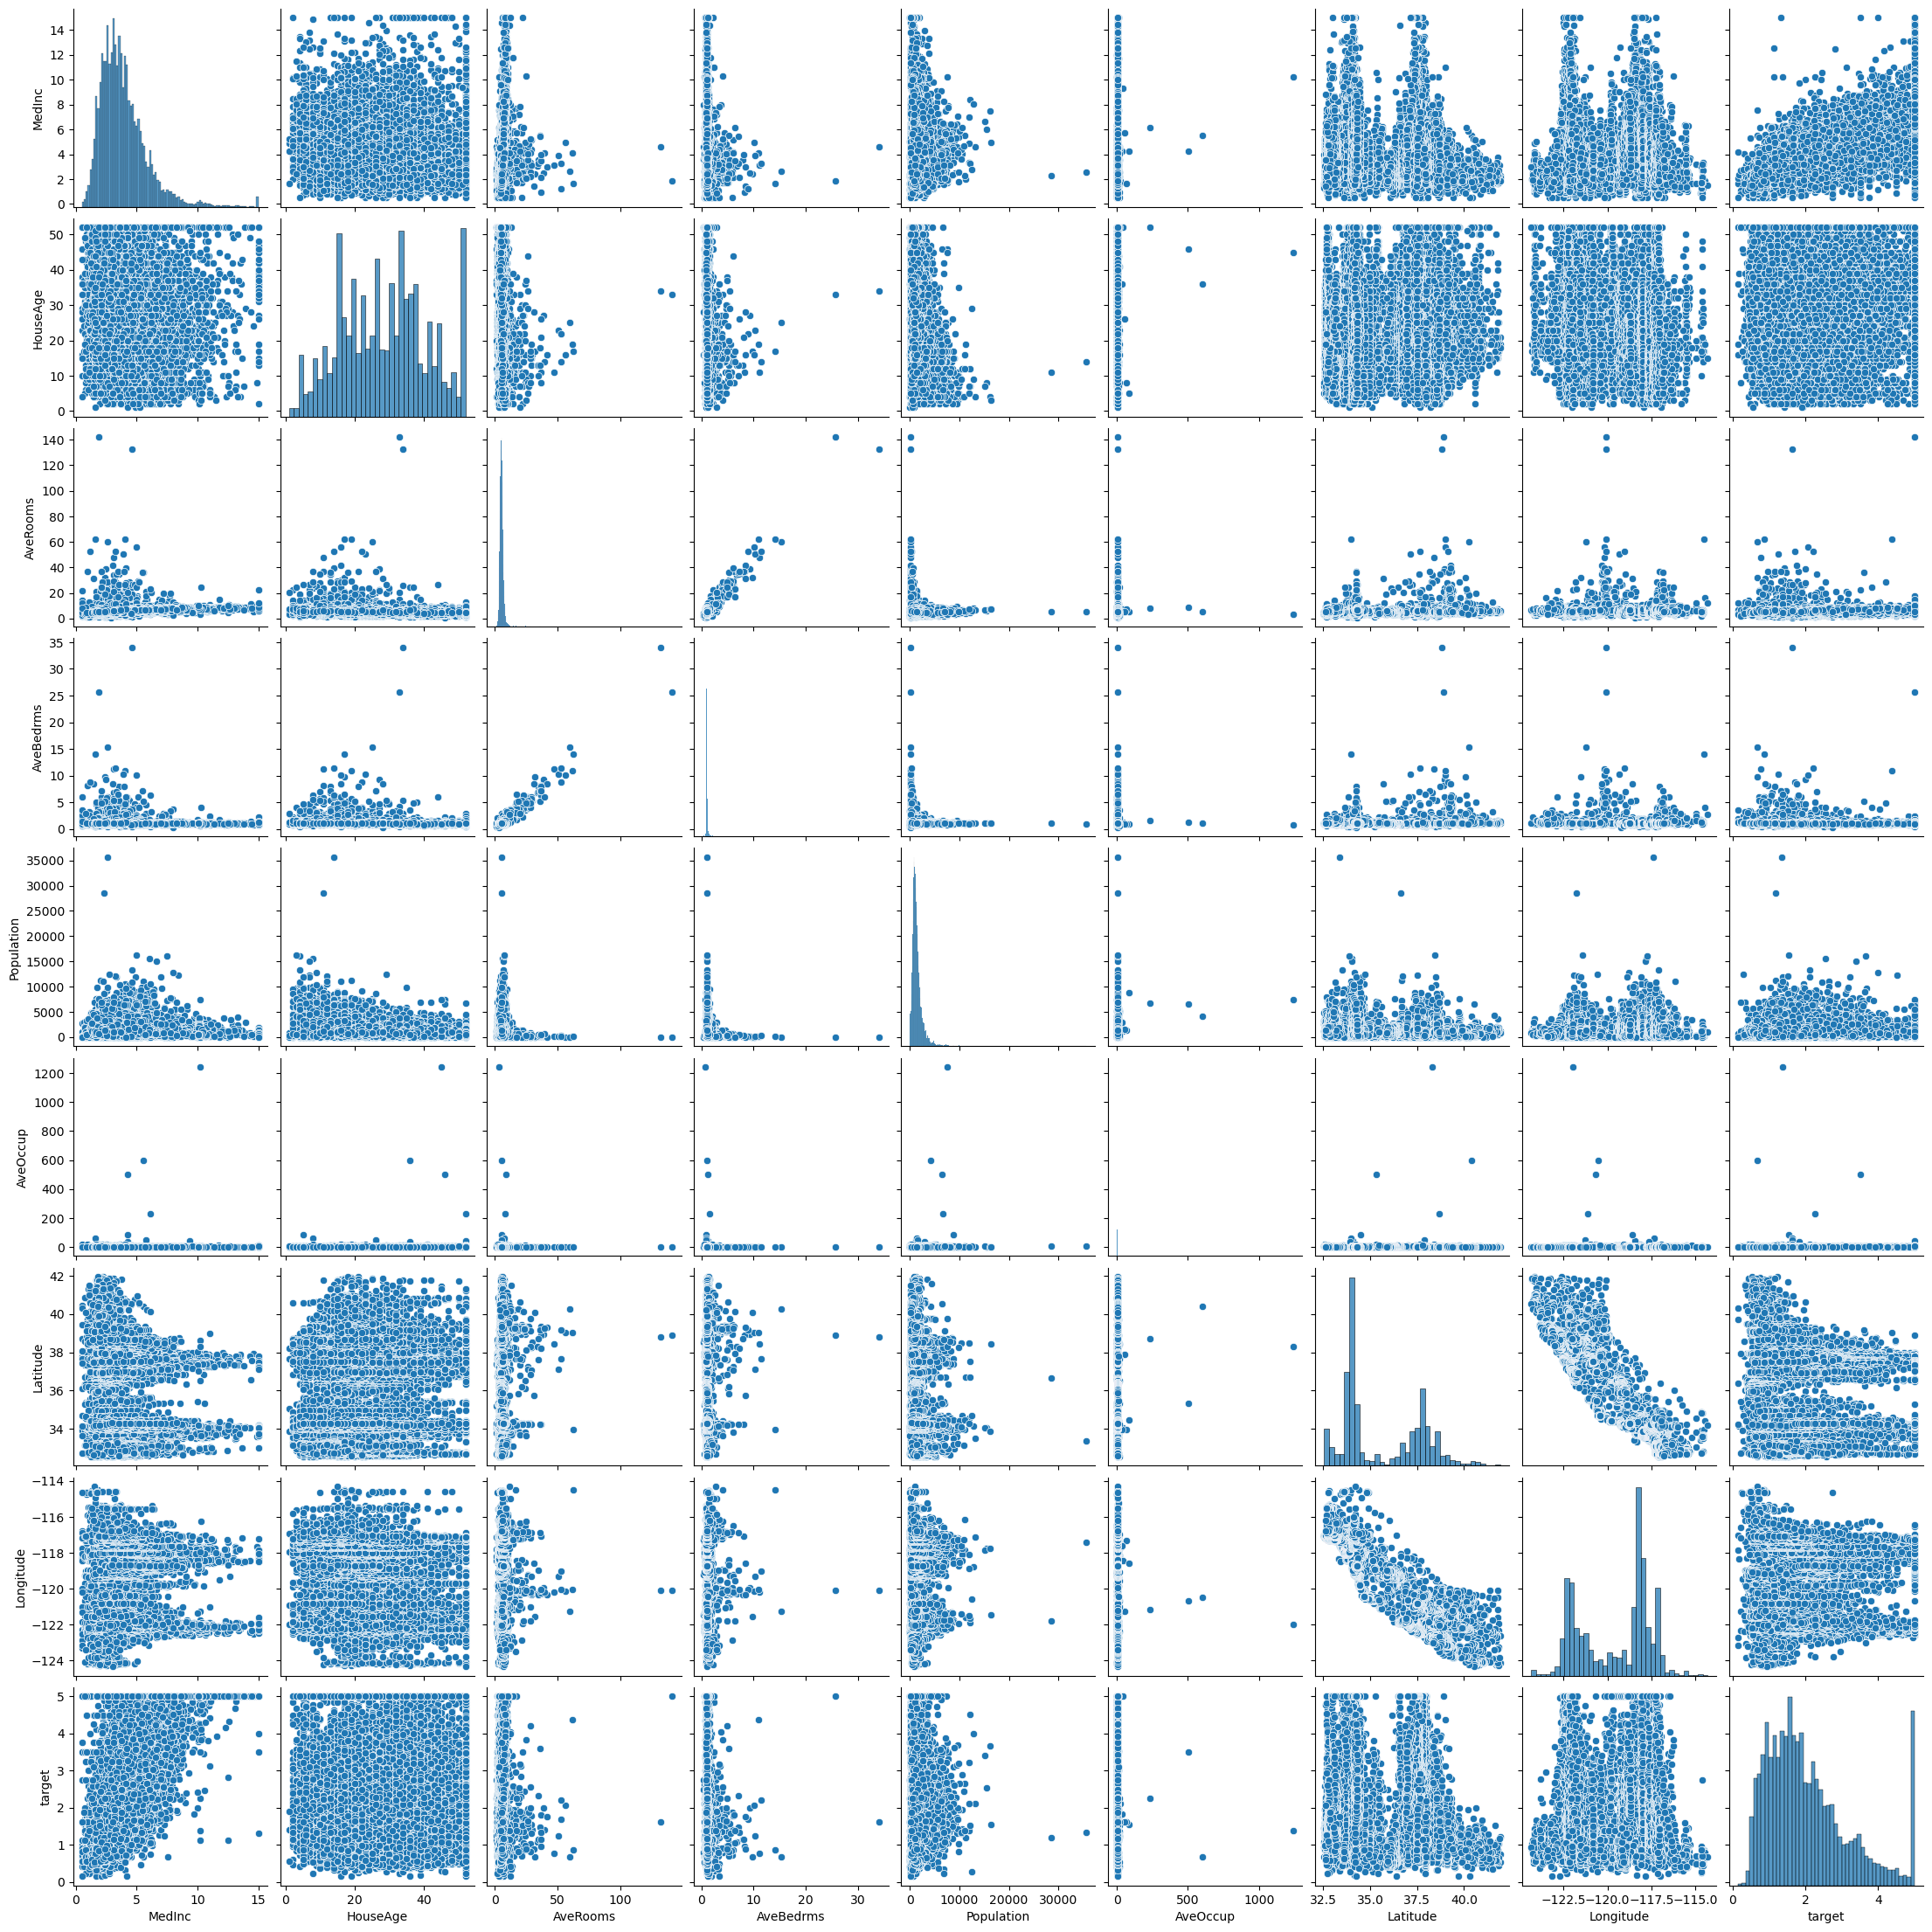

In [5]:
import seaborn as sns
plt.figure(figsize=(8, 4))
sns.pairplot(df)

"\n#MedInc: 90%以上統一\n#HouseAge: MinMax\n#AveRooms: 90%以上統一\n#AveBedrms: 90%以上統一\n#Population: 90%以上統一\n#AveOccup: high = df['AveOccup'].quantile(0.995), df.loc[df['AveOccup'] > high, 'AveOccup'] = high\n#Latitude: 保留加上分塊\n#Longitude: 保留加上分塊\n"

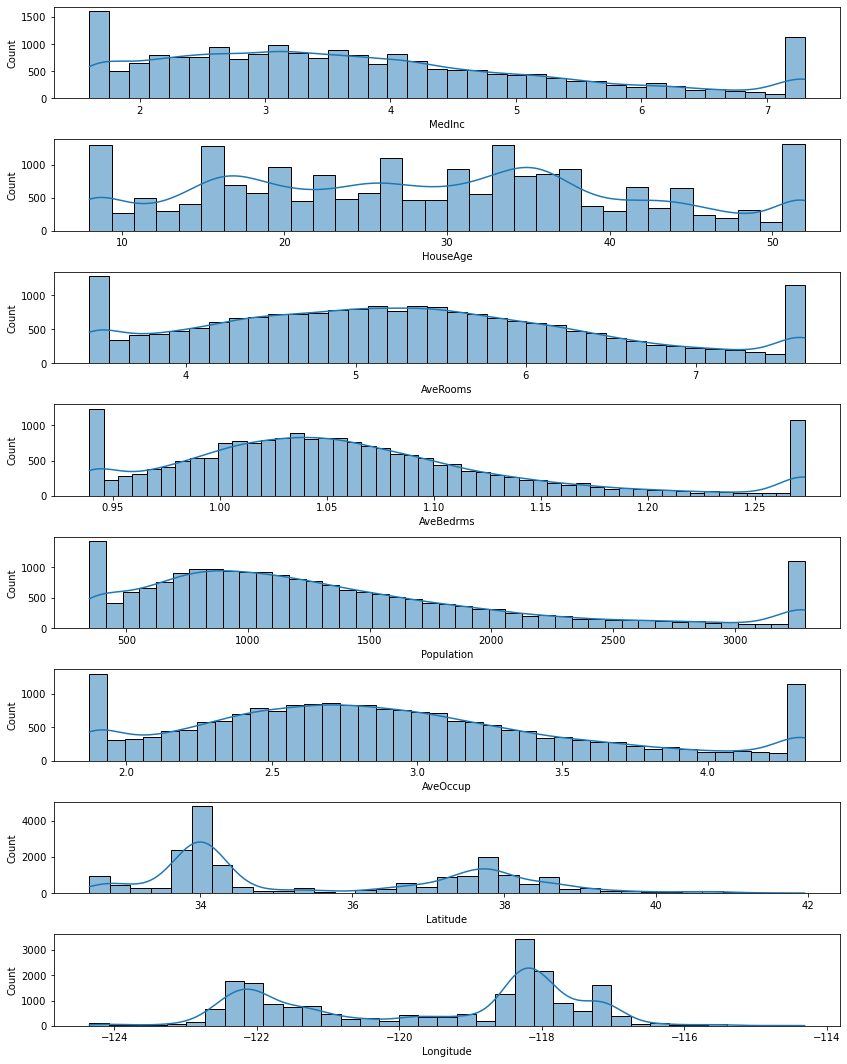

In [14]:
import seaborn as sns

cols = [i for i in df.columns if i != 'target']
fig, axs = plt.subplots(len(cols), 1, figsize=(12, 15))
fig.tight_layout(pad=2.0)

for c1, c2 in enumerate(cols):
    sns.histplot(data=df, x=c2, kde=True, ax=axs[c1])
'''
#MedInc: 90%以上統一
#HouseAge: MinMax
#AveRooms: 90%以上統一
#AveBedrms: 90%以上統一
#Population: 90%以上統一
#AveOccup: high = df['AveOccup'].quantile(0.995), df.loc[df['AveOccup'] > high, 'AveOccup'] = high
#Latitude: 保留加上分塊
#Longitude: 保留加上分塊
'''

<AxesSubplot:>

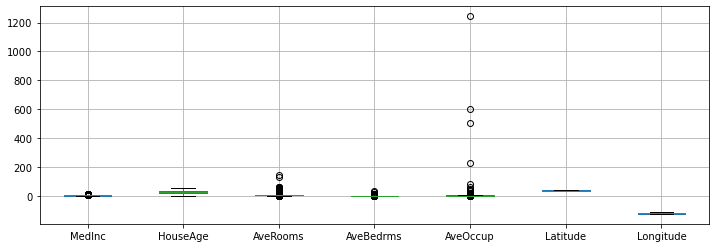

In [10]:
# 畫盒須圖
plt.figure(figsize=(12, 4))
boxplot_cols = [i for i in df.columns if i not in ['Population', 'target']]
df.boxplot(column=boxplot_cols)

In [5]:
# 用百分比剔除異常值
def quantile(data, colname, upper=0.05, lower=0.95):
    data[colname] = data[colname].astype(float)
    low = data[data[colname] > 0][colname].quantile(upper)
    high = data[data[colname] > 0][colname].quantile(lower)
    data.loc[data[colname] < low, colname] = low
    data.loc[data[colname] > high, colname] = high
    return data[colname]

"\nmaindf['BQ'] = maindf['BQ'].fillna(maindf['BQ'].min())\nmaindf['EL'] = maindf['EL'].fillna(maindf['EL'].mode()[0])\nmaindf['CB'] = maindf['CB'].fillna(maindf['CB'].median())\nmaindf['FC'] = maindf['FC'].fillna(maindf['FC'].mean())\nmaindf['FL'] = maindf['FL'].fillna(maindf['FL'].median())\nmaindf['EJ'] = maindf['EJ'].map({'A': 0, 'B': 1})\nmaindf.loc[(maindf['DU'].isnull()) & (maindf['Class']==0), 'DU'] = maindf.loc[maindf['Class']==0, 'DU'].median()\nmaindf.loc[maindf['CC'].isnull(), 'CC'] = maindf.loc[:, 'CC'].median()\n"

In [6]:
outlier_cols = [i for i in df.columns if i not in ['target', 'Latitude', 'Longitude']]
for col in outlier_cols:
    df[col] = df[col].fillna(df[col].median())
    df[col] = quantile(df, col)

<AxesSubplot:>

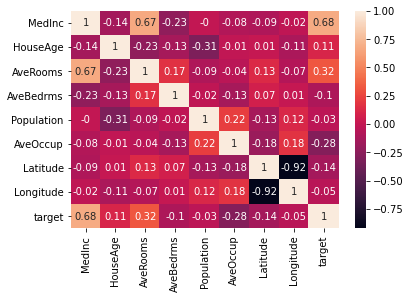

In [7]:
import seaborn as sns
corr = df.corr().round(2)
sns.heatmap(data=corr, annot=True)

In [8]:
# 標準化、歸一化
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler

cols = [i for i in housing['feature_names'] if i not in ['target', 'Latitude', 'Longitude']]
num_cols = [i for i in cols]
nor_cols = ['normal_'+i for i in cols]
std_cols = ['standard_'+i for i in cols]
Min_Max_cols = ['minmax_'+i for i in cols]
#Quantile_cols = ['quantile_'+i for i in cols]

df[nor_cols] = Normalizer().fit_transform(df[num_cols])
df[std_cols] = StandardScaler().fit_transform(df[num_cols])
df[Min_Max_cols] = MinMaxScaler().fit_transform(df[num_cols])
#df[Quantile_cols] = QuantileTransformer(n_quantiles=10, output_distribution="normal").fit_transform(df[num_cols])


In [6]:
df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [12]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# 用sklearn的pipeline來填補值
num = df.drop(columns=['target']).select_dtypes(include=['int64', 'float64']).columns
col = df.drop(columns=['target']).select_dtypes(include=['object']).columns

# Preprocessing for numerical data: imputation and scaling
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Preprocessing for categorical data: imputation and one-hot encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num),
        #('cat', categorical_transformer, col)
        ])

In [20]:
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor

model = XGBRegressor()
XBG_pipeline1 = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
XBG_pipeline2 = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])

voting = VotingRegressor(estimators=[
    ('Model1', XBG_pipeline1),
    ('Model2', XBG_pipeline2)
],weights=[0.5,0.5])

In [21]:
from sklearn.model_selection import train_test_split

trainX, testX, trainy, testy = train_test_split(df.drop(['target'], axis=1), df[['target']], train_size=0.8, random_state=0)

In [22]:
voting.fit(trainX, trainy)

VotingRegressor(estimators=[('Model1',
                             Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude'],
      dtype='object'))])),
                                             ('model',
                                              XGBRegressor(base_score...
                                                           importance_type=None,
                                                           interaction_constraints=None,
                                                           learning_rate=None,
                                                           max_bin=None,
                                                           max_cat_threshold=None,
                                                           max_cat_to_onehot=None,
                                                           max_delta_step=None,
                                                           max_depth=None,
                                                           max_leaves=None,
                                                           min_child_weight=None,
                                                           missing=nan,
                                                           monotone_constraints=None,
                                                           multi_strategy=None,
                                                           n_estimators=None,
                                                           n_jobs=None,
                                                           num_parallel_tree=None,
                                                           random_state=None, ...))]))],
                weights=[0.5, 0.5])

In [12]:
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import FactorAnalysis
from sklearn.cluster import KMeans

#GENES = [col for col in train_features.columns if col.startswith('g-')]
#CELLS = [col for col in train_features.columns if col.startswith('c-')]

#cols = [i for i in housing['feature_names'] if i not in ['target', 'Latitude', 'Longitude']]
cols = [i for i in housing['feature_names'] if i not in ['target', 'Latitude', 'Longitude']]

train_features = trainX[cols]
test_features = testX[cols]

IS_TRAIN = True
for col in cols:
    vec_len = len(train_features[col].values)
    vec_len_test = len(test_features[col].values)
    raw_vec = pd.concat([train_features, test_features])[col].values.reshape(vec_len+vec_len_test, 1)
    if IS_TRAIN:
        transformer = QuantileTransformer(n_quantiles=100, random_state=0, output_distribution="normal")
        transformer.fit(raw_vec)
        #pd.to_pickle(transformer, f'{MODEL_DIR}/{NB}_{col}_quantile_transformer.pkl')
    #else:
    #    transformer = pd.read_pickle(f'{MODEL_DIR}/{NB}_{col}_quantile_transformer.pkl')        

    train_features[col] = transformer.transform(train_features[col].values.reshape(vec_len, 1)).reshape(1, vec_len)[0]
    test_features[col] = transformer.transform(test_features[col].values.reshape(vec_len_test, 1)).reshape(1, vec_len_test)[0]

## Feature engineering for only train dataset and apply for test dataset
```Python
cols = [i for i in housing['feature_names'] if i not in ['target', 'Latitude', 'Longitude']]

train_features = trainX[cols]
test_features = testX[cols]

IS_TRAIN = True
for col in cols:
    vec_len = len(train_features[col].values)
    vec_len_test = len(test_features[col].values)
    raw_vec = train_features[col].values.reshape(vec_len, 1)
    if IS_TRAIN:
        transformer = QuantileTransformer(n_quantiles=100, random_state=0, output_distribution="normal")
        transformer.fit(raw_vec)
    train_features[col] = transformer.transform(train_features[col].values.reshape(vec_len, 1)).reshape(1, vec_len)[0]
    test_features[col] = transformer.transform(test_features[col].values.reshape(vec_len_test, 1)).reshape(1, vec_len_test)[0]
```

In [ ]:
# 經緯度裝箱分組，用於特徵是雙分佈
from sklearn.preprocessing import KBinsDiscretizer

## 分組
bin_encoder = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
binned_feature = bin_encoder.fit_transform(df[['Latitude', 'Longitude']])
df[['Latitude_binned', 'Longitude_binned']] = binned_feature
## 啞巴
Latitude_dummy = pd.get_dummies(df['Latitude_binned'], prefix='Latitude_binned_')
Longitude_dummy = pd.get_dummies(df['Longitude_binned'], prefix='Longitude_binned_')

df = pd.concat([df.drop(['target'], axis=1), Longitude_dummy, Latitude_dummy, df[['target']]], axis=1)
df.drop(['Latitude_binned', 'Longitude_binned'], axis=1, inplace=True)

In [ ]:
assert len(set(df.columns)) == len(df.columns)

In [ ]:
# 各種統計特徵: mean, std, max, min, last...
'''
df[['HouseAge', 'target']].groupby(['HouseAge']).mean().sort_index(ascending=False).reset_index(drop=False).head()
cols = df[['HouseAge', 'target']].groupby(['HouseAge']).aggregate({'target': ['count', 'sum', 'min', 'max']}).reset_index(drop=False).columns
'''

In [ ]:
# 交叉特徵
import pandas as pd
import itertools
def create_interaction_features(data, feature_columns, num_interactions):
    # Copy the original DataFrame to avoid modifying the original data
    new_data = data.copy()
    
    # Generate the interaction features
    for i in range(1, num_interactions+1):
        interaction_features = ['*'.join(features) for features in itertools.combinations(feature_columns, i)]
        for feature in interaction_features:
            new_data[feature] = new_data[feature_columns].prod(axis=1)
    return new_data

In [ ]:
'''interaction_cols = [i for i in df.columns if i not in ['target']]
num_interactions = 2
tmp_df = create_interaction_features(df, interaction_cols, num_interactions)'''

In [ ]:
from sklearn.feature_selection import SelectKBest
from scipy.stats import pearsonr
#from sklearn.feature_selection import chi2
'''

selector = SelectKBest(lambda X, Y: np.array(list(map(lambda x: pearsonr(x, Y), X.T))).T[0], k=20)
selector.fit(df.drop(['target'], axis=1), df[['target']])
cols_idxs = selector.get_support(indices=True)'''

selector = SelectKBest(lambda X, Y: np.array(list(map(lambda x: pearsonr(x, Y)[0], X.T))).T, k=20)
df_kbest = pd.DataFrame(selector.fit_transform(df.drop(['target'], axis=1), df['target']),columns=np.array(df.drop(['target'], axis=1).columns)[selector.get_support(indices=True)])



In [ ]:
# 計算相關係數：有order算P，數值算皮爾森
# 搭配Kbest
'''
from scipy import stats
grouped_data = df[['Latitude_binned', 'target']].groupby('Latitude_binned')['target']

# Perform ANOVA
f_value, p_value = stats.f_oneway(*[grouped_data.get_group(category) for category in grouped_data.groups])

print("F-value:", f_value)
print("P-value:", p_value)

if p_value < 0.05:
    print("ANOVA result is significant")
else:
    print("ANOVA result is not significant")'''

In [ ]:
# 其他表操作
'''
pd.merge(A, B, left_on='', right_on='')
pd.get_dummies(data, columns=[''], prefix=[''], dtype=[])
'''

In [ ]:
from sklearn.feature_selection import VarianceThreshold



In [ ]:
# Kfold操作
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
#from lightgbm import LGBMRegressor

# Define the parameter grid for GridSearchCV
param_grid = {
    'learning_rate': [0.1, 0.05, 0.01],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5]
}

# Define the KFold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the LightGBM regressor
xgb = XGBRegressor()

# Perform the GridSearchCV
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=kfold, scoring='neg_mean_squared_error')
grid_search.fit(trainX, trainy)

# Get the best estimator from the grid search
best_model = grid_search.best_estimator_

# Iterate over the folds and calculate the loss for each fold
fold_losses = []
best_model = np.NaN
for train_index, val_index in kfold.split(trainX, trainy):
    X_fold_train, X_fold_val = trainX.iloc[train_index, :], trainX.iloc[val_index, :]
    y_fold_train, y_fold_val = trainy.iloc[train_index, :], trainy.iloc[val_index, :]
    
    best_model.fit(X_fold_train, y_fold_train)
    y_val_pred = best_model.predict(X_fold_val)
    fold_loss = mean_squared_error(y_fold_val, y_val_pred)
    fold_losses.append(fold_loss)

# Print the loss for each fold
for fold, loss in enumerate(fold_losses):
    print(f"Fold {fold+1} Loss: {loss}")

# Print the best parameters, best score, and mean loss across folds
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)
print("Mean Loss across Folds:", np.mean(fold_losses))

# Predict on the test set
predy = best_model.predict(testX)

# Calculate the mean squared error
mse = mean_squared_error(testy, predy)

# Print the best parameters, best score, and mean squared error
print("Mean Squared Error:", mse)
print("Score:{}%".format(round(best_model.score(testX, testy)*100, 2)))

In [ ]:
# 其他模型
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

def custom_asymmetric_train(y_true, y_pred):
    residual = (y_true - y_pred).astype("float")
    grad = np.where(residual<0, -2*5.0*residual, -1*residual)
    hess = np.where(residual<0, 2*5.0, 1.0)
    return grad, hess

def xgboost_forecast_gridsearchcv(trainX, trainy, testX, testy):
    param_test1={"n_estimators":[100, 300],
                "max_depth": [3, 5, 7],
                "min_child_weight": [ 1.1, 3],
                "gamma":[0.0, 0.1],
                "colsample_bytree":[0.3], 
                "early_stopping_rounds":[10],
                "reg_alpha":[1], 
                "reg_lambda":[0.5]}
    gsc = GridSearchCV(estimator=XGBRegressor(booster='gbtree', 
                                              objective='reg:linear'),
                       param_grid = param_test1,
                       cv=5, verbose=0, n_jobs=-1)
    #grid_result = MultiOutputRegressor(gsc).fit(trainX, trainy)
    gsc.fit(trainX, trainy)
    best_estimator_ = gsc.best_params_
    yhat = gsc.predict(testX)
    return yhat, best_estimator_,gsc.score(testX, testy)


In [ ]:
yhat, best_est, score = xgboost_forecast_gridsearchcv(trainX, trainy, testX, testy)

In [ ]:
# 特徵重要性
import xgboost as xgb

fig, ax = plt.subplots(1, 1, figsize=(5, 10))
xgb.plot_importance(best_model, max_num_features=10, height=0.5, ax=ax)

In [ ]:
# XGBoost畫樹
#import xgboost as xgb

#xgb.plot_tree(best_model)

In [ ]:
#import pickle
#model.save_model('./model/housing.json')
model_name = 'xgboost(lr={}, max_depth={}, ntrees={})'.format(
    grid_search.best_params_['learning_rate'],
    grid_search.best_params_['max_depth'],
    grid_search.best_params_['n_estimators'])
best_model.save_model('./model/housing/{}.json'.format(model_name))


In [ ]:
# 重新載入模型

import xgboost
model = xgboost.XGBRegressor()
model.load_model('./model/housing/xgboost(lr=0.1, max_depth=5, ntrees=300).json')

In [ ]:
model.predict(testX).shape